In [16]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# importing data

df = pd.read_parquet('../data/rivm/COVID-19_aantallen_gemeente_per_dag.parquet')
display(df)

,Date_of_report,Date_of_publication,Municipality_code,Municipality_name,Province,Security_region_code,Security_region_name,Municipal_health_service,ROAZ_region,Total_reported,Hospital_admission,Deceased
0,2021-05-01 10:00:00,2020-02-27,GM0014,Groningen,Groningen,VR01,Groningen,GGD Groningen,Acute Zorgnetwerk Noord Nederland,0,0,0
1,2021-05-01 10:00:00,2020-02-27,GM0034,Almere,Flevoland,VR25,Flevoland,GGD Flevoland,SpoedZorgNet,0,0,0
2,2021-05-01 10:00:00,2020-02-27,GM0037,Stadskanaal,Groningen,VR01,Groningen,GGD Groningen,Acute Zorgnetwerk Noord Nederland,0,0,0
3,2021-05-01 10:00:00,2020-02-27,GM0047,Veendam,Groningen,VR01,Groningen,GGD Groningen,Acute Zorgnetwerk Noord Nederland,0,0,0
4,2021-05-01 10:00:00,2020-02-27,GM0050,Zeewolde,Flevoland,VR25,Flevoland,GGD Flevoland,SpoedZorgNet,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
162535,2021-05-01 10:00:00,2021-05-01,None,None,Limburg,VR23,Limburg-Noord,GGD Limburg-Noord,Netwerk Acute Zorg Limburg,1,0,0
162536,2021-05-01 10:00:00,2021-05-01,None,None,Limburg,VR24,Limburg-Zuid,GGD Zuid-Limburg,Netwerk Acute Zorg Limburg,2,0,0
162537,2021-05-01 10:00:00,2021-05-01,None,None,Zuid-Holland,VR15,Haaglanden,GGD Haaglanden,Netwerk Acute Zorg West,2,0,0
162538,2021-05-01 10:00:00,2021-05-01,None,None,Fryslân,VR02,Fryslân,GGD Fryslân,Acute Zorgnetwerk Noord Nederland,2,0,0


<ipython-input-17-d77a9f7e108c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



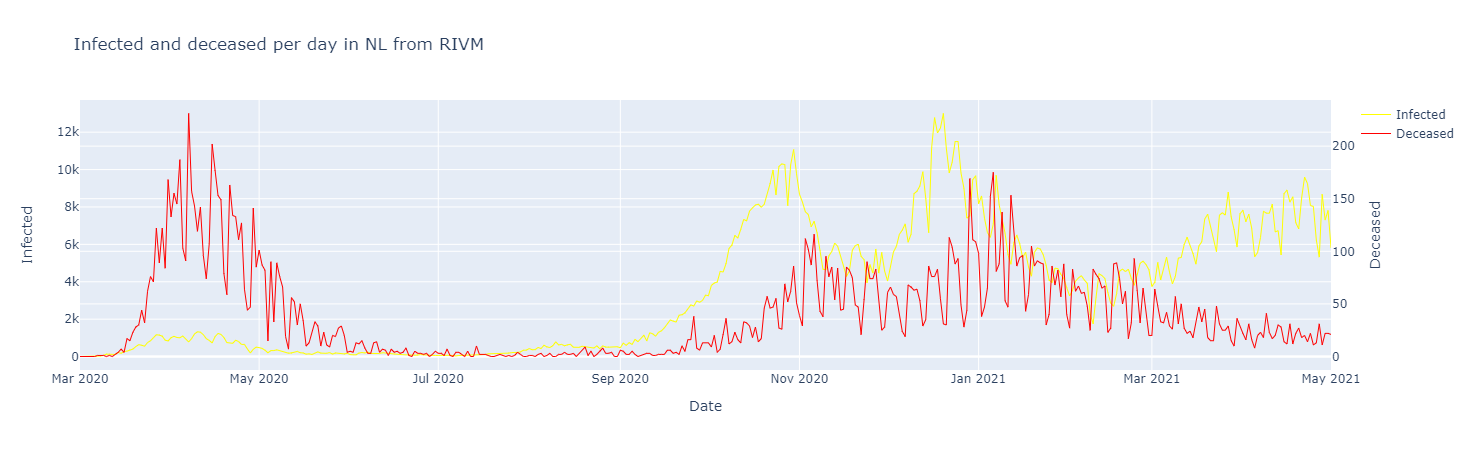

In [17]:
df_covid = df[['Date_of_publication', 'Total_reported', 'Deceased']]
df_covid.columns = ['date', 'infected', 'deceased']
df_covid['date'] = df_covid['date'].astype('datetime64[ns]')
df_covid = df_covid[df_covid['date'] >= "2020-03-01"]
df_covid = df_covid.groupby(by=['date']).sum()
df_covid['infected'], df_covid['deceased'] = df_covid['infected'].astype('float'), df_covid['deceased'].astype('float')
df_covid["date"] = df_covid.index

fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=df_covid["date"], y=df_covid["infected"], name='Infected', line=dict(color='yellow', width=1), yaxis='y1')) # , dash='dot')))
fig.add_trace(go.Scatter(x=df_covid["date"], y=df_covid["deceased"], name='Deceased', line=dict(color='red', width=1), yaxis='y2')) # , dash='dot')))

# Edit the layout
fig.update_layout(title='Infected and deceased per day in NL from RIVM', xaxis_title='Date', yaxis=dict(title='Infected'), yaxis2=dict(title='Deceased', overlaying='y', side='right'))

fig.show()

In [70]:
df_covid_deceased = df_covid[["deceased"]]
df_covid_deceased = df_covid_deceased["2021-01-04" <= df_covid_deceased.index]
df_covid_deceased = df_covid_deceased[df_covid_deceased.index < "2021-04-26"]
display(df_covid_deceased)

,deceased
date,
2021-01-04,65.0
2021-01-05,152.0
2021-01-06,175.0
2021-01-07,81.0
2021-01-08,88.0
...,...
2021-04-21,18.0
2021-04-22,20.0
2021-04-23,14.0


In [71]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df_covid_deceased)

(0.01, False)

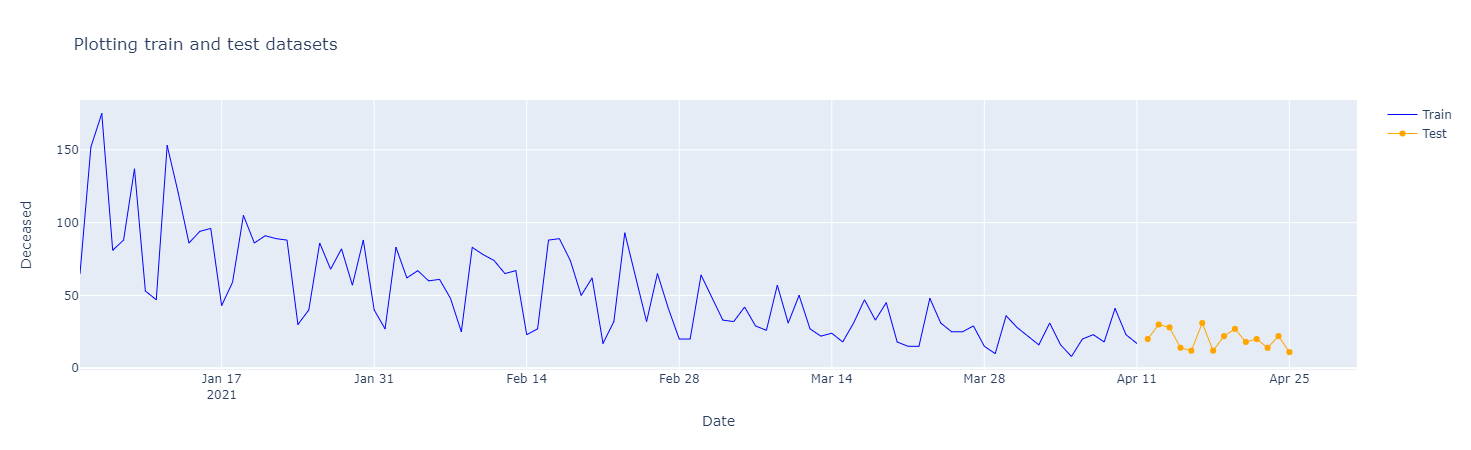

In [72]:
train = df_covid_deceased[df_covid_deceased.index <= "2021-04-11"]
test = df_covid_deceased[df_covid_deceased.index > "2021-04-11"]
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=train.index, y=train["deceased"], name='Train', line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=test.index, y=test["deceased"], name='Test', line=dict(color='orange', width=1)))

# Edit the layout
fig.update_layout(title='Plotting train and test datasets', xaxis_title='Date', yaxis=dict(title='Deceased'))

fig.show()

In [73]:
from pmdarima import auto_arima
arima_model = auto_arima(train, start_p = 0, d = 1, start_q = 0,
                        max_p = 5, max_d = 5, max_q = 5, start_P = 0,
                        D = 1, start_Q = 0, max_P = 5, max_D = 5,
                        max_Q = 5, m = 7, seasonal = True,
                        error_action = "warn", trace = True,
                        supress_warnings = True, stepwise = True,
                        random_state = 20, n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=818.989, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=793.939, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=751.895, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=752.005, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=751.115, Time=0.20 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=753.105, Time=0.07 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=750.099, Time=0.29 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=748.254, Time=0.25 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=750.254, Time=0.41 sec
 ARIMA(0,1,1)(3,1,1)[7]             : AIC=751.869, Time=0.55 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=806.711, Time=0.09 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=748.082, Time=0.33 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=752.967, Time=0.09 sec
 ARIMA(1,1,1)(3,1,0)[7]             : AIC=749.943, Time=0.48 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=749.1

In [74]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   98
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 7)   Log Likelihood                -365.599
Date:                            Sun, 02 May 2021   AIC                            743.198
Time:                                    16:51:23   BIC                            758.197
Sample:                                         0   HQIC                           749.246
                                             - 98                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2874      0.107     -2.695      0.007      -0.497      -0.078
ar.L2         -0.3147      0.110     -2.856      0.004      -0.531      -0.099
ma.L1         -0.7721      0.101     -7.623      0.000      -0.971      -0.574
ar.S.L7       -0.2030      0.120     -1.694      0.090      -0.438       0.032
ar.S.L14      -0.3326      0.111     -2.985      0.003      -0.551      -0.114
sigma2       189.6687     33.341      5.689      0.000     124.322     255.015
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.11
Prob(Q):                              0.94   Prob(JB):                         0.21
Heteroskedasticity (H):               0.46   Skew:                            -0.44
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 14), index=test.index)
prediction.columns = ["predicted_deceased"]
prediction

,predicted_deceased
date,
2021-04-12,8.156562
2021-04-13,24.604819
2021-04-14,23.566558
2021-04-15,18.249263
2021-04-16,37.016347
2021-04-17,22.191484
2021-04-18,14.765761
2021-04-19,7.029288
2021-04-20,27.226510


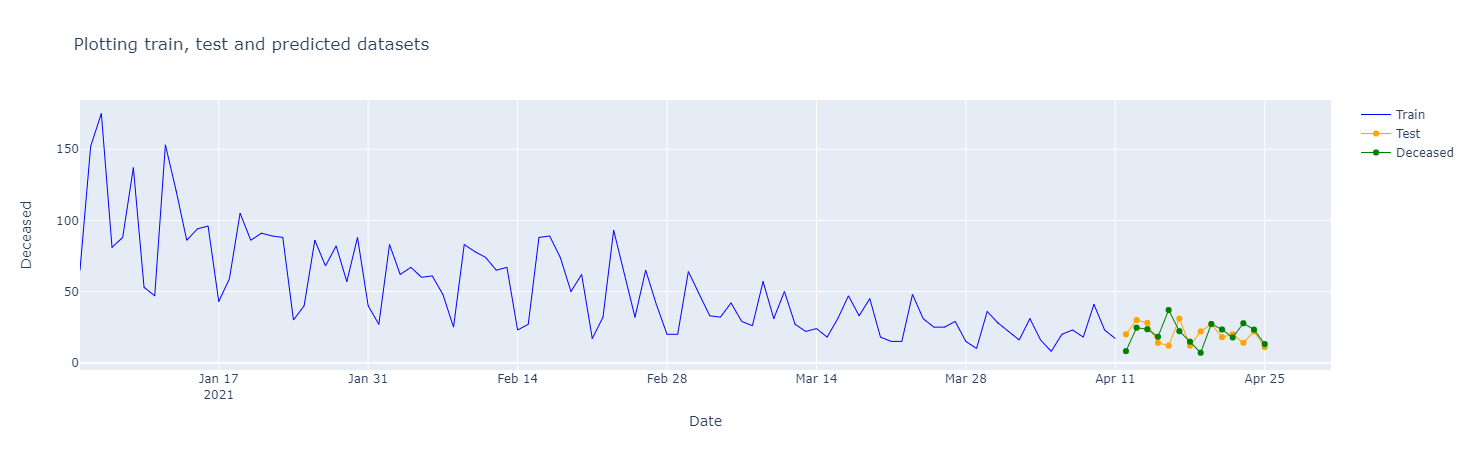

In [76]:
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=train.index, y=train["deceased"], name='Train', line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=test.index, y=test["deceased"], name='Test', line=dict(color='orange', width=1)))
fig.add_trace(go.Scatter(x=prediction.index, y=prediction["predicted_deceased"], name='Deceased', line=dict(color='green', width=1)))

# Edit the layout
fig.update_layout(title='Plotting train, test and predicted datasets', xaxis_title='Date', yaxis=dict(title='Deceased'))

fig.show()

In [77]:
from sklearn.metrics import r2_score
test["predicted_deceased"] = prediction
r2_score(test["deceased"], test["predicted_deceased"])

<ipython-input-77-27f2e7aa34f5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-1.1876778969483577